<a href="https://colab.research.google.com/github/vincm1/UK_accidents/blob/main/Final_assignment_Big_Data_for_Decision_Making_(2021_22_BNK432_NO02_A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final assignment - Big Data for Decision Making (2021-22 BNK432_NO02_A)**

### **Load dataset**

In [595]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [596]:
df = pd.read_csv("UK Road Accidents 2018.csv")
df.head()

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area
0,2018-01-01 00:00:00,18,Monday,Fine,False,Dry,Darkness - lights lit,Urban
1,2018-01-01 01:00:00,9,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
2,2018-01-01 02:00:00,14,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
3,2018-01-01 03:00:00,10,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
4,2018-01-01 04:00:00,8,Monday,Fine,False,Dry,Darkness - lights lit,Urban


## **1)** **Business** **objective and context**

The above seen dataset is published by the UK Department for Transport and is published sinced 1978. For this report, a snippet of the data is taken and handles all UK road accidents that happened in 2018 on an hourly level. Furthermore, it shows which day of the week it has been, the condition of precipitation within that time as well as whether there was high wind. Moreover, the dataset contains information about the road surface conditions, light conditions and in what kind of area the accidents in that hour happened.

The goal of this report is to forecast the number of hourly accidents occuring on UK streets for Britannia Rescue in order to help its rescourcing planning by an appropriate forecasting model.

To predict the numbers the following report structure will be included. First, the data will explored and preprocessed. Secondly, the features are selected and a baseline model will be drawn. Thirdly, models will be trained, hyperparameters tuned and thereby evaluated, which model shows the best performance for predicting road accidents for the client. To sum up, the results will be discussed and further steps will be introduced.

### Data inspection 

In [597]:
df.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area'],
      dtype='object')

In [598]:
df.shape

(8540, 8)

In [599]:
df.describe()

,Count
count,8540.000000
mean,14.358548
std,10.479488
min,1.000000
25%,5.000000
50%,13.000000
75%,21.000000
max,62.000000


In [600]:
df.dtypes

datetime                   object
Count                       int64
Day_of_Week                object
Precipitation              object
High_Winds                   bool
Road_Surface_Conditions    object
Light_Conditions           object
Urban_or_Rural_Area        object
dtype: object

Creating more granularity for date info

In [601]:
df["datetime"] = pd.to_datetime(df["datetime"])

In [602]:
df["day"] = df["datetime"].dt.date
df["day"] = pd.to_datetime(df["day"])

In [603]:
df["day_n"] = df["datetime"].dt.day

In [604]:
df["hour"] = df["datetime"].dt.hour

In [605]:
df["month"] = df["datetime"].dt.month_name()

In [606]:
df["month_n"] = df["datetime"].dt.month

In [607]:
df.loc[(df['Day_of_Week'] == 'Saturday') | (df['Day_of_Week'] == 'Sunday'), 'Weekend'] = 'Weekend'
df.loc[(df['Day_of_Week'] != 'Saturday') & (df['Day_of_Week'] != 'Sunday'), 'Weekend'] = 'Weekday'  

In [608]:
conditions_season = [
                     ((df["month"] == "December") | (df["month"] == "January") | (df["month"] == "February")),
                     ((df["month"] == "March") | (df["month"] == "April") | (df["month"] == "May")),
                     ((df["month"] == "June") | (df["month"] == "July") | (df["month"] == "August")),
                     (df["month"] == "September") | (df["month"] == "October") | (df["month"] == "November")
]

values_season = ["Winter","Spring","Summer","Autumn"]

df["Season"] = np.select(conditions_season, values_season)

In [609]:
cat_names = ['Day_of_Week', 'Weekend','Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'month','Weekend','Season','hour']
print("Unique count of categorical features:")
for i in cat_names:
  print(i,df[i].unique().size)

Unique count of categorical features:
Day_of_Week 7
Weekend 2
Precipitation 7
High_Winds 2
Road_Surface_Conditions 6
Light_Conditions 5
Urban_or_Rural_Area 2
month 12
Weekend 2
Season 4
hour 24


In [610]:
for i in cat_names:
  print(i,df[i].unique())

Day_of_Week ['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
Weekend ['Weekday' 'Weekend']
Precipitation ['Fine' 'Other' 'Raining' 'Fog or mist' 'Unknown' 'Snowing'
 'Data missing or out of range']
High_Winds [False  True]
Road_Surface_Conditions ['Dry' 'Wet or damp' 'Frost or ice' 'Snow' 'Flood over 3cm. deep'
 'Data missing or out of range']
Light_Conditions ['Darkness - lights lit' 'Daylight' 'Darkness - no lighting'
 'Darkness - lighting unknown' 'Darkness - lights unlit']
Urban_or_Rural_Area ['Urban' 'Rural']
month ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'November' 'December']
Weekend ['Weekday' 'Weekend']
Season ['Winter' 'Spring' 'Summer' 'Autumn']
hour [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [611]:
print(f"From ",df["day"].min(), "to ", df["day"].max(),": " ,df.Count.sum()," accidents occured.")

From  2018-01-01 00:00:00 to  2018-12-31 00:00:00 :  122622  accidents occured.


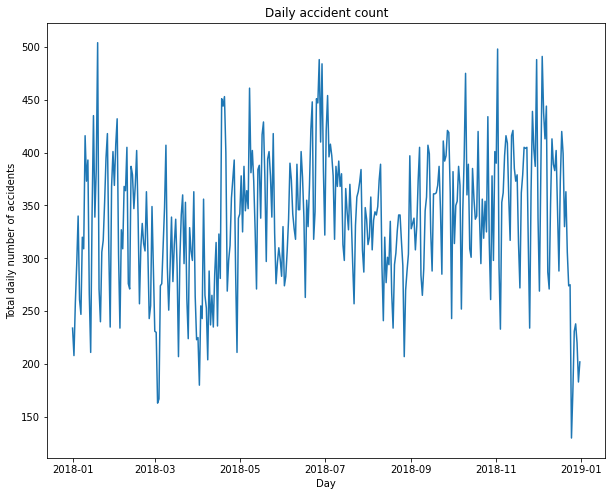

In [612]:
acc_daily = df.groupby("day").sum("Count")
acc_daily.drop(columns=["High_Winds","day_n","month_n",'hour'],inplace=True)

plt.figure(figsize=(10,8))
plt.title("Daily accident count")
plt.plot(acc_daily)
plt.xlabel("Day")
plt.ylabel("Total daily number of accidents")
plt.show()

## **2) Descriptive Statistics (EDA)**

### Train / Test Split

In [613]:
train_set,test_set = train_test_split(df,test_size=0.2, random_state=7, shuffle=False)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

6832 train and 1708 test instances


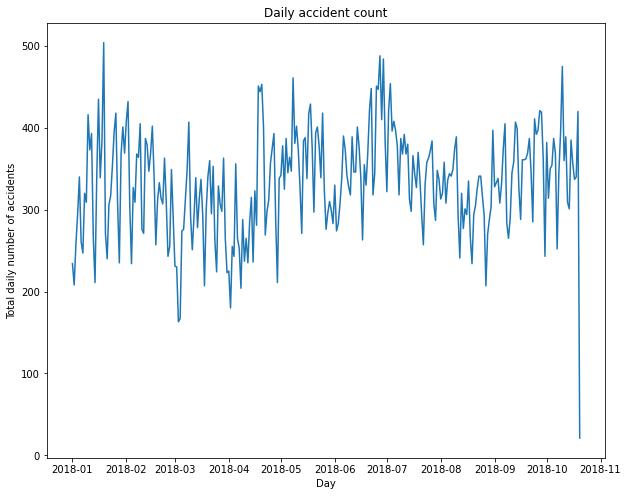

In [614]:
acc_daily_train = train_set.groupby("day").sum("Count")
acc_daily_train.drop(columns=["High_Winds","day_n","month_n",'hour'],inplace=True)
#acc_daily_train
plt.figure(figsize=(10,8))
plt.title("Daily accident count")
plt.plot(acc_daily_train)
plt.xlabel("Day")
plt.ylabel("Total daily number of accidents")
plt.show()

In [615]:
print(f"As the graph shows the daily accident numbers swing between:", acc_daily_train["Count"].max(),"as maximum and",acc_daily_train["Count"].min(),"minimun." )

As the graph shows the daily accident numbers swing between: 504 as maximum and 21 minimun.


In [616]:
train_set.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area',
       'day', 'day_n', 'hour', 'month', 'month_n', 'Weekend', 'Season'],
      dtype='object')

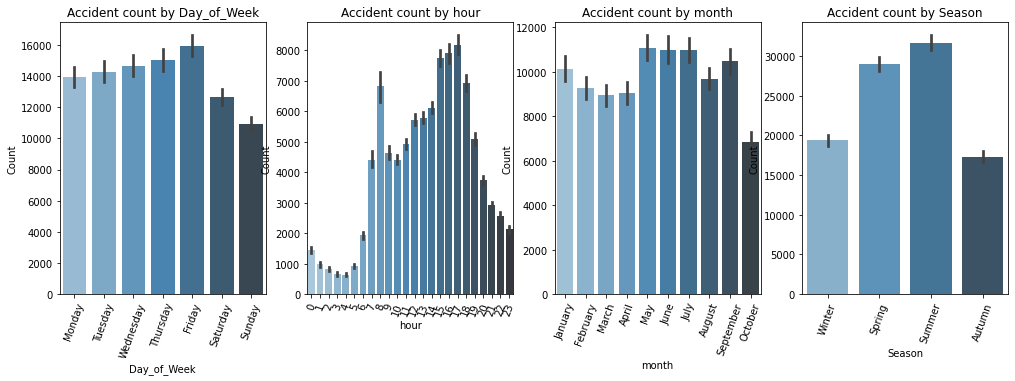

In [617]:
c = 1

fig = plt.figure(figsize=(17,5))

for i in df[["Day_of_Week",'hour','month','Season']]:
    plt.subplot(1, 4, c)
    plt.title(f'Accident count by {i}')
    plt.xlabel(i)
    plt.xticks(rotation=70)
    sns.barplot(x=i,y="Count",data=train_set,estimator=sum, palette="Blues_d")
    c = c + 1

plt.show()

Concerning the date and time of the data one can recognize that accidents are evenly distributed between the weekdays and only *sligthly* peak on Fridays and have a *slight* bottom on Sundays. 
Regarding the hours there is a more clear distribution towards the rush hour hours from 16:00 to 18:00 as well as in the mornings between 7:00 and 9:00. 

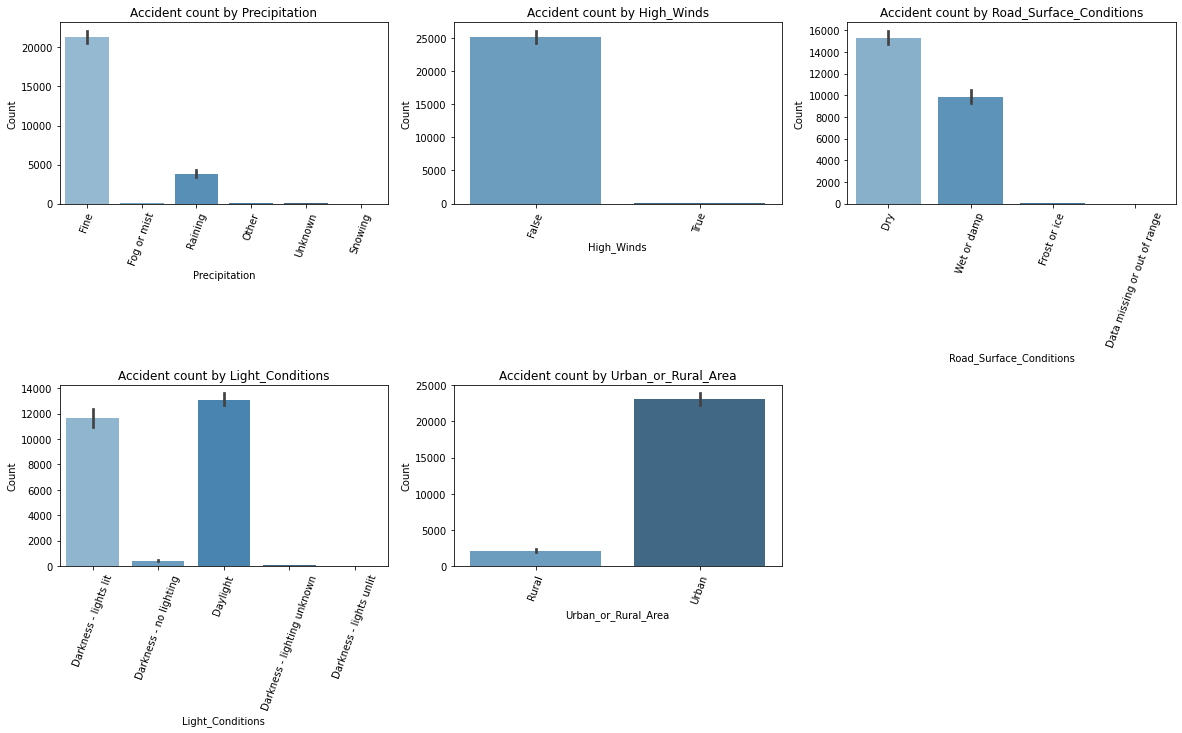

In [618]:
c = 1

fig = plt.figure(figsize=(20,10))

for i in df[['Precipitation',
       'High_Winds', 'Road_Surface_Conditions', 'Light_Conditions',
       'Urban_or_Rural_Area']]:
    plt.subplot(2, 3, c)
    plt.subplots_adjust(hspace=1)
    plt.title(f'Accident count by {i}')
    plt.xlabel(i)
    plt.xticks(rotation=70)
    sns.barplot(x=i,y="Count",data=test_set,estimator=sum, palette="Blues_d")
    c = c + 1

plt.show()

The graphs above all describe the features that are more related towards the features relating to the external circumstances of an accident. The first two graphs show that most accidents happen on fine precipation and without high winds. Furhtermore, graph 3 and 4 show that the majority occurs on dry conditions on daylight. Finally, there seems to be an overweight of accidents happen in urban areas. Also it feature values that are rare luke Darkness - lights unit oder frosty road conditions might consolidate into another variable value in the data preprocessing stage.

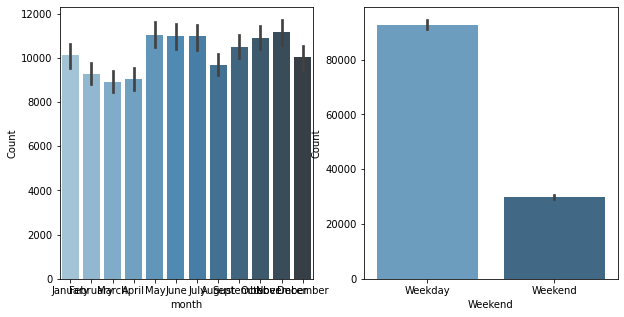

In [619]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
sns.barplot(ax= axes[0], data=df, x='month', y='Count',estimator=sum,palette="Blues_d")
sns.barplot(ax=axes[1], data=df, x='Weekend', y='Count',estimator=sum,palette="Blues_d")
plt.show()

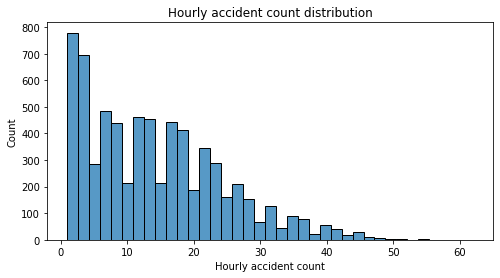

In [620]:
plt.figure(figsize=(8,4))
sns.histplot(data=train_set, x="Count")
plt.title("Hourly accident count distribution")
plt.xlabel("Hourly accident count")
plt.show()

## **3)** **Data Preprocessing**


In [621]:
train_set.isna().sum()

datetime                   0
Count                      0
Day_of_Week                0
Precipitation              0
High_Winds                 0
Road_Surface_Conditions    0
Light_Conditions           0
Urban_or_Rural_Area        0
day                        0
day_n                      0
hour                       0
month                      0
month_n                    0
Weekend                    0
Season                     0
dtype: int64

In [622]:
test_set.isna().sum()

datetime                   0
Count                      0
Day_of_Week                0
Precipitation              0
High_Winds                 0
Road_Surface_Conditions    0
Light_Conditions           0
Urban_or_Rural_Area        0
day                        0
day_n                      0
hour                       0
month                      0
month_n                    0
Weekend                    0
Season                     0
dtype: int64

In [623]:
for i in train_set[['Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area']]:
    x = train_set[i].value_counts()
    print("Column name is: ",i,"and its unique value counts are:",x)

Column name is:  Day_of_Week and its unique value counts are: Saturday     985
Friday       982
Sunday       981
Monday       979
Wednesday    972
Thursday     971
Tuesday      962
Name: Day_of_Week, dtype: int64
Column name is:  Precipitation and its unique value counts are: Fine                            6094
Raining                          528
Snowing                          116
Other                             41
Unknown                           37
Fog or mist                       15
Data missing or out of range       1
Name: Precipitation, dtype: int64
Column name is:  High_Winds and its unique value counts are: False    6775
True       57
Name: High_Winds, dtype: int64
Column name is:  Road_Surface_Conditions and its unique value counts are: Dry                             5346
Wet or damp                     1308
Snow                             115
Frost or ice                      49
Data missing or out of range       9
Flood over 3cm. deep               5
Name: Road_Sur

In [624]:
train_set.loc[train_set["Road_Surface_Conditions"].str.contains("Flood"), "Road_Surface_Conditions"] = "Wet or damp"

In [625]:
indexNames = train_set[(train_set['Precipitation'] == "Unknown") | (train_set['Precipitation'] == "Data missing or out of range") | (train_set["Road_Surface_Conditions"] == "Data missing or out of range")].index
train_set.drop(indexNames , inplace=True)


In [626]:
for i in train_set[['Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area']]:
    x = train_set[i].value_counts()
    print("Column name is: ",i,"and its unique value counts are:",x)

Column name is:  Day_of_Week and its unique value counts are: Saturday     981
Friday       977
Monday       975
Sunday       973
Wednesday    967
Thursday     967
Tuesday      952
Name: Day_of_Week, dtype: int64
Column name is:  Precipitation and its unique value counts are: Fine           6092
Raining         528
Snowing         116
Other            41
Fog or mist      15
Name: Precipitation, dtype: int64
Column name is:  High_Winds and its unique value counts are: False    6735
True       57
Name: High_Winds, dtype: int64
Column name is:  Road_Surface_Conditions and its unique value counts are: Dry             5329
Wet or damp     1300
Snow             115
Frost or ice      48
Name: Road_Surface_Conditions, dtype: int64
Column name is:  Light_Conditions and its unique value counts are: Daylight                       4107
Darkness - lights lit          2202
Darkness - no lighting          386
Darkness - lighting unknown      75
Darkness - lights unlit          22
Name: Light_Conditio

In [627]:
for i in test_set[['Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area']]:
    x = test_set[i].value_counts()
    print("Column name is: ",i,"and its unique value counts are:",x)

Column name is:  Day_of_Week and its unique value counts are: Sunday       263
Saturday     258
Monday       255
Friday       235
Wednesday    234
Thursday     233
Tuesday      230
Name: Day_of_Week, dtype: int64
Column name is:  Precipitation and its unique value counts are: Fine           1398
Raining         280
Unknown          11
Other            10
Fog or mist       8
Snowing           1
Name: Precipitation, dtype: int64
Column name is:  High_Winds and its unique value counts are: False    1696
True       12
Name: High_Winds, dtype: int64
Column name is:  Road_Surface_Conditions and its unique value counts are: Dry                             957
Wet or damp                     745
Frost or ice                      4
Data missing or out of range      2
Name: Road_Surface_Conditions, dtype: int64
Column name is:  Light_Conditions and its unique value counts are: Darkness - lights lit          867
Daylight                       691
Darkness - no lighting         124
Darkness - ligh

In [628]:
indexNames_test = test_set[(test_set['Precipitation'] == "Unknown") | (test_set["Road_Surface_Conditions"] == "Data missing or out of range")].index
test_set.drop(indexNames_test , inplace=True)

In [629]:
for i in test_set[['Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area']]:
    x = test_set[i].value_counts()
    print("Column name is: ",i,"and its unique value counts are:",x)

Column name is:  Day_of_Week and its unique value counts are: Sunday       263
Saturday     257
Monday       250
Friday       234
Thursday     233
Wednesday    232
Tuesday      228
Name: Day_of_Week, dtype: int64
Column name is:  Precipitation and its unique value counts are: Fine           1398
Raining         280
Other            10
Fog or mist       8
Snowing           1
Name: Precipitation, dtype: int64
Column name is:  High_Winds and its unique value counts are: False    1685
True       12
Name: High_Winds, dtype: int64
Column name is:  Road_Surface_Conditions and its unique value counts are: Dry             954
Wet or damp     739
Frost or ice      4
Name: Road_Surface_Conditions, dtype: int64
Column name is:  Light_Conditions and its unique value counts are: Darkness - lights lit          863
Daylight                       691
Darkness - no lighting         121
Darkness - lighting unknown     19
Darkness - lights unlit          3
Name: Light_Conditions, dtype: int64
Column name 

Comparing the value counts of each feature, "Data that was out of range", "Unknown" was dropped from the dataset. Furthermore, 5 lines of data with the value "Flood over 3cm was attached to "wet or dump surface conditions". The same feature preprocessing steps were conducted for the test data set.

In [630]:
cat_vals = ['Precipitation', 'High_Winds','Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'Weekend','Season']
vals = train_set[cat_vals]

In [631]:
categ = ['Precipitation','High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area','Weekend', 'Season']

In [632]:
lenc = LabelEncoder()

In [633]:
train_set_lenc = train_set.copy()

In [634]:
train_set_lenc[categ] = train_set_lenc[categ].apply(lenc.fit_transform)

In [635]:
train_set_lenc.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area',
       'day', 'day_n', 'hour', 'month', 'month_n', 'Weekend', 'Season'],
      dtype='object')

In [636]:
train_set_lenc = train_set_lenc[['datetime', 'Count', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'day_n', 'hour', 'month_n', 'Weekend', 'Season']]
train_set_lenc.head()

,datetime,Count,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,day_n,hour,month_n,Weekend,Season
0,2018-01-01 00:00:00,18,0,0,0,1,1,1,0,1,0,3
1,2018-01-01 01:00:00,9,0,0,3,1,1,1,1,1,0,3
2,2018-01-01 02:00:00,14,0,0,3,1,1,1,2,1,0,3
3,2018-01-01 03:00:00,10,0,0,3,1,1,1,3,1,0,3
4,2018-01-01 04:00:00,8,0,0,0,1,1,1,4,1,0,3


In [637]:
test_set_lenc = test_set.copy()
test_set_lenc[categ] = test_set_lenc[categ].apply(lenc.fit_transform)
test_set_lenc = test_set_lenc[['datetime', 'Count', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'day_n', 'hour', 'month_n', 'Weekend', 'Season']]
test_set_lenc.head()

,datetime,Count,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,day_n,hour,month_n,Weekend,Season
6832,2018-10-20 05:00:00,2,0,0,0,1,0,20,5,10,1,0
6833,2018-10-20 06:00:00,3,1,0,0,3,1,20,6,10,1,0
6834,2018-10-20 07:00:00,7,0,0,0,4,0,20,7,10,1,0
6835,2018-10-20 08:00:00,3,0,0,0,4,0,20,8,10,1,0
6836,2018-10-20 09:00:00,12,0,0,0,4,1,20,9,10,1,0


## **4) Feature construction & selection**

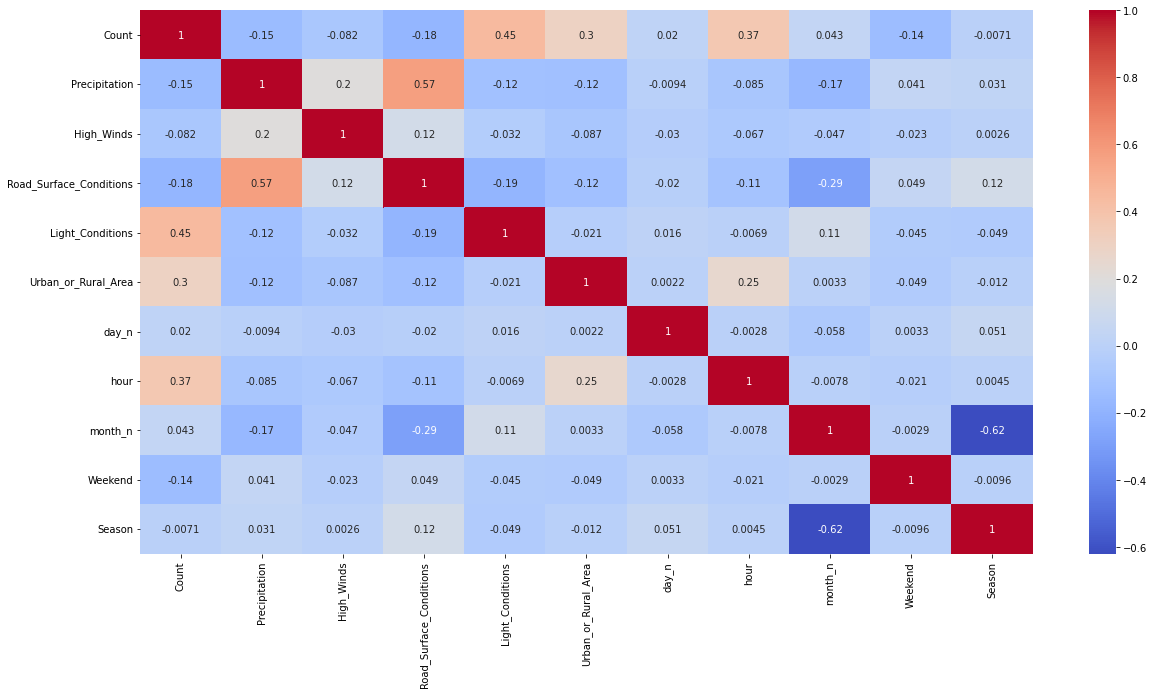

In [638]:
corr_mat_lenc = train_set_lenc.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat_lenc, annot=True, cmap="coolwarm")
plt.show()

The correlation heatmap shows that there seems to be no strong multicollinearity between the features, only month and season seem to have some multicollinearity as these values are close to -1. 

Moreover, considering the correlation between target variable "Count" and the features, "High winds", "Season", "day_n", "month_n" and "Season" will not be considered as features of the model since it appears to be that these variables have no influence on the target variable. Therefore, the variables "Precipitation", "Road Surface Conditions", "Area", "hour", and "Weekend" will serve as feature for the models.

## **5) Baseline Model**

In [639]:
median_accident_count = train_set_lenc["Count"].median()
print(f"There are:", median_accident_count,"accidents per hour.")

There are: 13.0 accidents per hour.


In [640]:
yhat =  np.full((train_set_lenc.shape[0],1), median_accident_count)

In [641]:
baseline_mse = mean_squared_error(train_set_lenc["Count"],yhat)
print(f"The baseline MSE is:",baseline_mse)

baseline_rmse = np.sqrt(baseline_mse)
print(f"The basline RMSE is:",baseline_rmse)

The baseline MSE is: 108.2946113074205
The basline RMSE is: 10.406469685124755


The RMSE of 10.4 of the baseline model indicates the amount by which the baseline gets hourly accident count wrong. On average 10.6 accident deviations, which is quite a big amount comparing to the mean of 13 accidents per hour. This suggests this is a difficult problem to solve.

### **Seperating X and y variables**

In [642]:
X_train = train_set_lenc[["Precipitation","Road_Surface_Conditions", "Light_Conditions","Urban_or_Rural_Area","hour","Weekend"]]
X_test =  test_set_lenc[["Precipitation","Road_Surface_Conditions", "Light_Conditions","Urban_or_Rural_Area","hour","Weekend"]]

In [643]:
y_train = train_set_lenc["Count"]
y_test= pd.DataFrame(test_set_lenc["Count"].reset_index(drop=True))

## **6) Random Forest Regression Model**


In [644]:
rfr = RandomForestRegressor(max_depth = 2, n_estimators=10)

In [645]:
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=10)

In [646]:
y_pred_rfr = rfr.predict(X_test)
y_pred_rfr

array([ 3.48203353,  6.59047118, 20.74851925, ...,  9.77264757,
        9.77264757,  9.77264757])

In [647]:
rfr_mse = mean_squared_error(y_test, y_pred_rfr)
rfr_mse

65.1173668315537

In [648]:
rfr_rmse = np.sqrt(rfr_mse)
rfr_rmse

8.069533247440877

In [649]:
cv_scores_rfr = cross_val_score(rfr, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

In [650]:
rmse_cv_scores_rfr = np.sqrt(-cv_scores_rfr)

print(f"Scores:",rmse_cv_scores_rfr)
print(f"Scores mean:",rmse_cv_scores_rfr.mean())
print(f"Scores std:",rmse_cv_scores_rfr.std())
print(f"Scores min:",rmse_cv_scores_rfr.min())
print(f"Scores max:",rmse_cv_scores_rfr.max())

Scores: [7.65538218 6.46666244 7.00299741 7.60620391 7.69672521 6.96063438
 7.79460623 5.90750223 6.74009151 7.52443512]
Scores mean: 7.1355240623851
Scores std: 0.596012576318403
Scores min: 5.907502232017112
Scores max: 7.794606225418739


In [651]:
param_grid_rfr = [
                {'n_estimators':[3,5,10,30,50], 'max_depth':[2,4,6,8,None]}
]

In [652]:
grid_search_rfr = GridSearchCV(rfr,param_grid_rfr,cv=10, scoring='neg_mean_squared_error', return_train_score=True)


In [653]:
grid_search_rfr.fit(X_train,y_train)
cv_rfr_df = pd.DataFrame(grid_search_rfr.cv_results_)
cv_rfr_df[["params","mean_test_score","mean_train_score"]].head()

,params,mean_test_score,mean_train_score
0,"{'max_depth': 2, 'n_estimators': 3}",-51.309844,-50.777261
1,"{'max_depth': 2, 'n_estimators': 5}",-51.191153,-50.764595
2,"{'max_depth': 2, 'n_estimators': 10}",-51.225662,-50.767080
3,"{'max_depth': 2, 'n_estimators': 30}",-51.230852,-50.764644
4,"{'max_depth': 2, 'n_estimators': 50}",-51.241998,-50.763359


In [654]:
grid_search_rfr.best_estimator_

RandomForestRegressor(max_depth=8, n_estimators=50)

In [655]:
np.sqrt(-grid_search_rfr.best_score_)

5.345084154533287

In [656]:
feature_importances_rfr = grid_search_rfr.best_estimator_.feature_importances_
for k, v in sorted(zip(feature_importances_rfr,X_train.columns), reverse=True):
  print(f"{v}: {k}")

hour: 0.9048744728616278
Weekend: 0.06341421970058769
Urban_or_Rural_Area: 0.012404526227817868
Road_Surface_Conditions: 0.00788118230845325
Precipitation: 0.006985004390502284
Light_Conditions: 0.004440594511011055


The feature importance indicates, that the Random forrest regressor highly weights the hour, an accident happens compared to other forecast features. One could consider, removing road surface conditions and precipitation as least important features.

In [657]:
best_rfr = grid_search_rfr.best_estimator_
yhat_rfr = best_rfr.predict(X_test)

final_mse_rfr = mean_squared_error(y_test, yhat_rfr)
final_rmse_rfr = np.sqrt(final_mse_rfr)
final_rmse_rfr

6.291211055249843

After tuning the parameters max. depth and number of estimators in the Random Forrest Regressor has a RMSE of 5.31, which is much better compared to baseline RMSE of 10.4. Also comparing to the initial and train data RMSE and cross validated RMSE of 7.03 and 5.41, one can conclude that the model's quality increased by tuning the hyperparameters and also with unseen test data.

In [658]:
yhat_rfr = pd.DataFrame(yhat_rfr)

rfr_eval = []
rfr_eval = pd.DataFrame(columns=["y_test","y_hat"])
rfr_eval["y_test"] = y_test["Count"]
rfr_eval["y_hat"] = yhat_rfr[0]
rfr_eval.set_index(test_set["datetime"], inplace=True)
rfr_eval

,y_test,y_hat
datetime,,
2018-10-20 05:00:00,2,3.911990
2018-10-20 06:00:00,3,4.236985
2018-10-20 07:00:00,7,5.043047
2018-10-20 08:00:00,3,7.435388
2018-10-20 09:00:00,12,11.100166
...,...,...
2018-12-31 19:00:00,13,18.176992
2018-12-31 20:00:00,12,12.763027
2018-12-31 21:00:00,5,10.239588


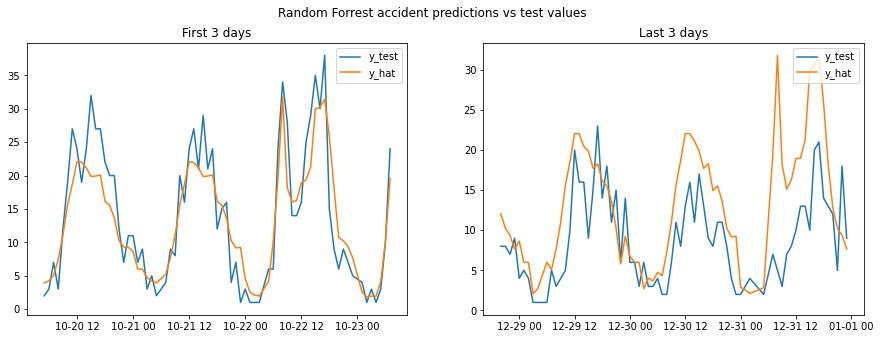

In [659]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Random Forrest accident predictions vs test values')
ax1.plot(rfr_eval[:72])
ax1.set_title("First 3 days")
ax1.legend(labels=rfr_eval.columns,loc="upper right")
ax2.plot(rfr_eval[-72:])
ax2.set_title("Last 3 days")
ax2.legend(labels=rfr_eval.columns,loc="upper right")
plt.show()

The graphs show the first and last three days of the test data and compares the predicted and real accident counts. One can recognize that the model does not have included high peaks such as on day xy.

## **7) Decision Tree Regressor Model**


In [660]:
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.1, random_state=None)

In [661]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.1)

In [662]:
y_pred_dt = dt.predict(X_test)

In [663]:
mse_dt = mean_squared_error(y_test,y_pred_dt)
print(f" The mean squared error for Decision Tree Regressor is:", mse_dt)


 The mean squared error for Decision Tree Regressor is: 57.514975332035306


In [664]:
rmse_dt = np.sqrt(mse_dt)
print(f"The root means squared error for the Decision Tree Model is:", rmse_dt)

The root means squared error for the Decision Tree Model is: 7.583862823919965


In [665]:
cv_scores_dt = cross_val_score(dt,X_train, y_train,scoring="neg_mean_squared_error",cv=10)

In [666]:
rmse_cv_scores_dt = np.sqrt(-cv_scores_dt)
print(f"Scores:",rmse_cv_scores_dt)
print(f"Scores mean:",rmse_cv_scores_dt.mean())
print(f"Scores std:",rmse_cv_scores_dt.std())
print(f"Scores min:",rmse_cv_scores_dt.min())
print(f"Scores max:",rmse_cv_scores_dt.max())

Scores: [7.45003878 6.43717572 6.9364206  7.20589084 7.09424622 6.23052973
 7.1605127  5.24110831 6.40427296 7.31115045]
Scores mean: 6.7471346324220125
Scores std: 0.640192701964665
Scores min: 5.241108313675444
Scores max: 7.450038783723772


In [667]:
param_grid_dt = [
                {'max_depth':[4,8,10,30,50], 'min_samples_leaf':[2,4,6,8]}
]

In [668]:
grid_search_dt = GridSearchCV(dt,param_grid_dt,cv=10, scoring='neg_mean_squared_error', return_train_score=True)


In [669]:
grid_search_dt.fit(X_train,y_train)
cv_dt_df = pd.DataFrame(grid_search_dt.cv_results_)
cv_dt_df[["params","mean_test_score","mean_train_score"]].head()

,params,mean_test_score,mean_train_score
0,"{'max_depth': 4, 'min_samples_leaf': 2}",-40.423506,-39.707317
1,"{'max_depth': 4, 'min_samples_leaf': 4}",-40.423506,-39.707317
2,"{'max_depth': 4, 'min_samples_leaf': 6}",-40.423506,-39.707317
3,"{'max_depth': 4, 'min_samples_leaf': 8}",-40.423506,-39.707317
4,"{'max_depth': 8, 'min_samples_leaf': 2}",-29.068586,-25.960895


In [670]:
grid_search_dt.best_params_

{'max_depth': 8, 'min_samples_leaf': 4}

In [671]:
np.sqrt(-grid_search_dt.best_score_)

5.385672122376105

In [672]:
feature_importances_dt = grid_search_dt.best_estimator_.feature_importances_
for k, v in sorted(zip(feature_importances_dt,X_train.columns), reverse=True):
  print(f"{v}: {k}")

hour: 0.912220855584255
Weekend: 0.06359179864513974
Urban_or_Rural_Area: 0.011068412463248026
Precipitation: 0.006409557475277203
Road_Surface_Conditions: 0.004247236646497668
Light_Conditions: 0.002462139185582265


In [673]:
best_dt = grid_search_dt.best_estimator_
yhat_dt = best_dt.predict(X_test)

final_mse_dt = mean_squared_error(y_test, yhat_dt)
final_rmse_dt = np.sqrt(final_mse_dt)
final_rmse_dt

6.313504188173666

In [674]:
yhat_dt = pd.DataFrame(yhat_dt)

In [675]:
dt_eval = []
dt_eval = pd.DataFrame(columns=["y_test","y_hat_dt"])
dt_eval["y_test"] = y_test["Count"]
dt_eval["y_hat_dt"] = yhat_dt[0]
dt_eval.set_index(test_set["datetime"], inplace=True)

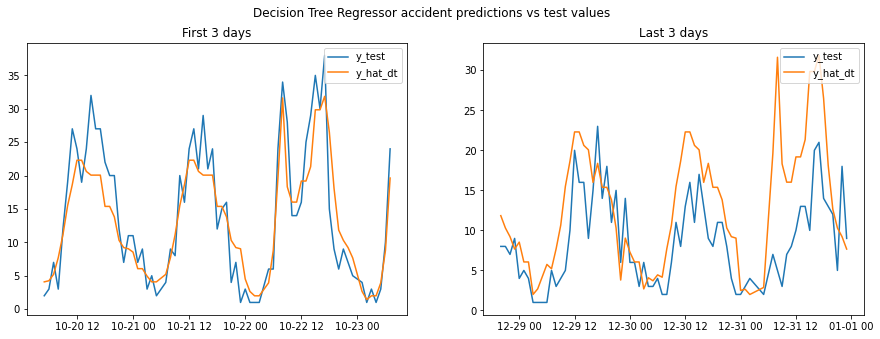

In [676]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Decision Tree Regressor accident predictions vs test values')
ax1.plot(dt_eval[:72])
ax1.set_title("First 3 days")
ax1.legend(labels=dt_eval.columns,loc="upper right")
ax2.plot(dt_eval[-72:])
ax2.set_title("Last 3 days")
ax2.legend(labels=dt_eval.columns,loc="upper right")
plt.show()

## **8) XG Boost Model**

In [677]:
xgbr = XGBRegressor(verbosity=0)

In [678]:
xgbr.fit(X_train, y_train)

XGBRegressor(verbosity=0)

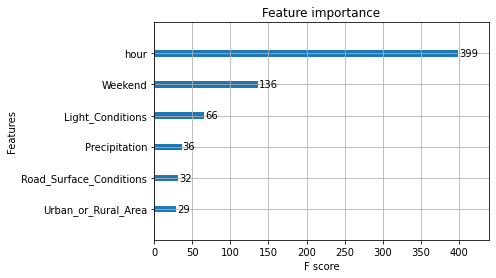

In [679]:
xgb.plot_importance(xgbr, ax=plt.gca())

In [680]:
score = xgbr.score(X_train, y_train)
score

0.7382183339743784

In [681]:
y_pred_xgbr = xgbr.predict(X_test)
y_pred_xgbr

array([ 3.8004894,  3.9561522,  5.188753 , ..., 10.167215 ,  9.261363 ,
        8.053736 ], dtype=float32)

In [682]:
mse_xgbr = mean_squared_error(y_test,y_pred_xgbr)
print(f" The mean squared error for XG Boost regressor is:", mse_xgbr)

 The mean squared error for XG Boost regressor is: 39.28474713556978


In [683]:
rmse_xgbr = np.sqrt(mse_xgbr)
print(f"The root mean squared error for the XG Boost regressor model is:", rmse_dt)

The root mean squared error for the XG Boost regressor model is: 7.583862823919965


In [684]:
cv_scores_xgbr = cross_val_score(xgbr, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

In [685]:
rmse_cv_scores_xgbr = np.sqrt(-cv_scores_xgbr)
print(f"Scores:",rmse_cv_scores_xgbr)
print(f"Scores mean:",rmse_cv_scores_xgbr.mean())
print(f"Scores std:",rmse_cv_scores_xgbr.std())
print(f"Scores min:",rmse_cv_scores_xgbr.min())
print(f"Scores max:",rmse_cv_scores_xgbr.max())

Scores: [6.0031298  5.27524924 5.46919649 6.00347156 5.35935665 4.96722735
 5.68023488 5.00898259 5.12827913 5.56766644]
Scores mean: 5.446279413449482
Scores std: 0.3534389697141405
Scores min: 4.967227353330363
Scores max: 6.003471557066975


In [686]:
param_grid_xgbr = [
                {'n_estimators:': [50,100,200], 'max_depth':[2,3,5,10,15]}
]

In [687]:
grid_search_xgbr = GridSearchCV(xgbr,param_grid_xgbr,cv=10, scoring='neg_mean_squared_error', return_train_score=True)

In [688]:
grid_search_xgbr.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=XGBRegressor(verbosity=0),
             param_grid=[{'max_depth': [2, 3, 5, 10, 15],
                          'n_estimators:': [50, 100, 200]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [689]:
cv_xgbr_df = pd.DataFrame(grid_search_xgbr.cv_results_)
cv_xgbr_df[["params","mean_test_score","mean_train_score"]].head()

,params,mean_test_score,mean_train_score
0,"{'max_depth': 2, 'n_estimators:': 50}",-35.055363,-33.717390
1,"{'max_depth': 2, 'n_estimators:': 100}",-35.055363,-33.717390
2,"{'max_depth': 2, 'n_estimators:': 200}",-35.055363,-33.717390
3,"{'max_depth': 3, 'n_estimators:': 50}",-29.786879,-28.003472
4,"{'max_depth': 3, 'n_estimators:': 100}",-29.786879,-28.003472


In [690]:
grid_search_xgbr.best_params_

{'max_depth': 5, 'n_estimators:': 50}

In [691]:
np.sqrt(-grid_search_xgbr.best_score_)

5.353363210597978

In [692]:
feature_importances_xgbr = grid_search_xgbr.best_estimator_.feature_importances_
for k, v in sorted(zip(feature_importances_xgbr,X_train.columns), reverse=True):
  print(f"{v}: {k}")

hour: 0.7530237436294556
Weekend: 0.16346770524978638
Urban_or_Rural_Area: 0.0386623851954937
Road_Surface_Conditions: 0.020648352801799774
Light_Conditions: 0.0126896221190691
Precipitation: 0.011508186347782612


In [693]:
best_xgbr = grid_search_xgbr.best_estimator_
yhat_xgbr = best_xgbr.predict(X_test)

final_mse_xgbr = mean_squared_error(y_test, yhat_xgbr)
final_rmse_xgbr = np.sqrt(final_mse_xgbr)
final_rmse_xgbr

6.4343076975791345

In [694]:
yhat_xbgr = pd.DataFrame(yhat_xgbr)

In [695]:
xgbr_eval = []
xgbr_eval = pd.DataFrame(columns=["y_test","y_hat_xgbr"])
xgbr_eval["y_test"] = y_test["Count"]
xgbr_eval["y_hat_xgbr"] = yhat_xgbr
xgbr_eval.set_index(test_set["datetime"], inplace=True)

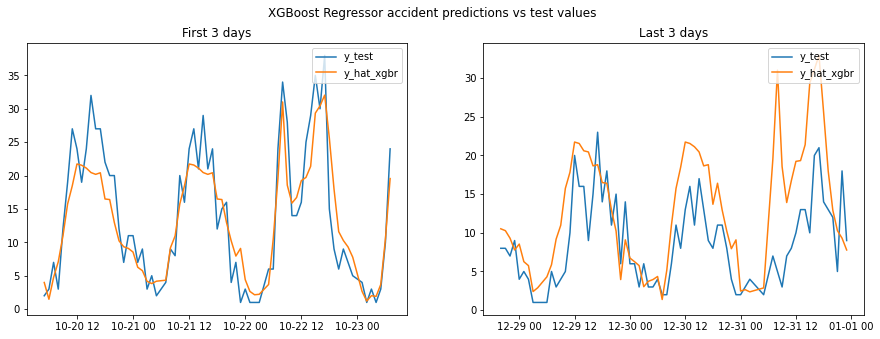

In [696]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('XGBoost Regressor accident predictions vs test values')
ax1.plot(xgbr_eval[:72])
ax1.set_title("First 3 days")
ax1.legend(labels=xgbr_eval.columns,loc="upper right")
ax2.plot(xgbr_eval[-72:])
ax2.set_title("Last 3 days")
ax2.legend(labels=xgbr_eval.columns,loc="upper right")
plt.show()

## **9) Discussion of evaluation results**

In [697]:
print(f"Baseline model RMSE:", baseline_rmse)
print(f"Final Random Forrest Regressor RMSE:", final_rmse_rfr)
print(f"Final Decision Tree Regressor RMSE:", final_rmse_dt)
print(f"Final model XGBoost Regressor RMSE:", final_rmse_xgbr)

Baseline model RMSE: 10.406469685124755
Final Random Forrest Regressor RMSE: 6.291211055249843
Final Decision Tree Regressor RMSE: 6.313504188173666
Final model XGBoost Regressor RMSE: 6.4343076975791345


Comparing the three models with the baseline model one can summarize, that all models have a better quality than the baseline model and therefore predict the hourly accident count more precise. The most accurate model comparing RMSE's is the Random Forrest Regressor, with an RMSE of 6.21. 

Still all RMSE's indicate that the models wrongly predict the accident count on average by 6.21 to 6.85. Therefore, one can conclude that further improvements should be conducted before handling the model into production.

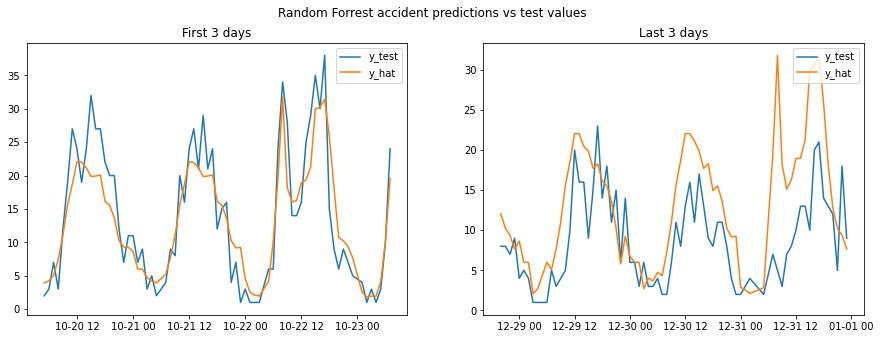

In [698]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Random Forrest accident predictions vs test values')
ax1.plot(rfr_eval[:72])
ax1.set_title("First 3 days")
ax1.legend(labels=rfr_eval.columns,loc="upper right")
ax2.plot(rfr_eval[-72:])
ax2.set_title("Last 3 days")
ax2.legend(labels=rfr_eval.columns,loc="upper right")
plt.show()

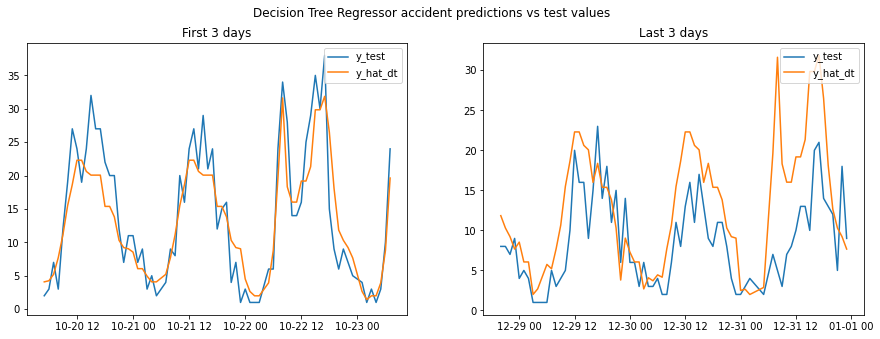

In [699]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Decision Tree Regressor accident predictions vs test values')
ax1.plot(dt_eval[:72])
ax1.set_title("First 3 days")
ax1.legend(labels=dt_eval.columns,loc="upper right")
ax2.plot(dt_eval[-72:])
ax2.set_title("Last 3 days")
ax2.legend(labels=dt_eval.columns,loc="upper right")
plt.show()

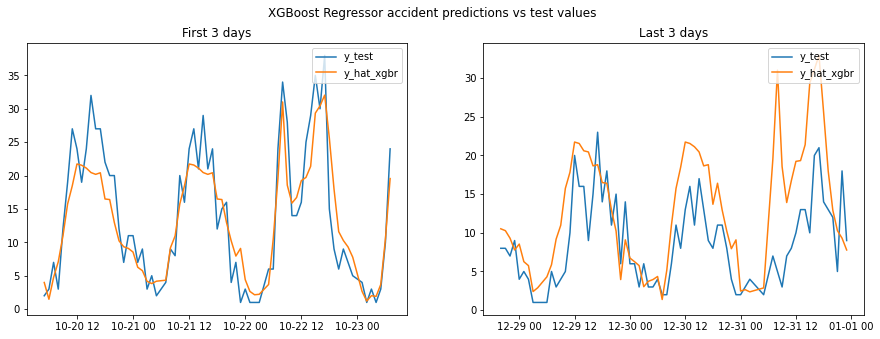

In [700]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('XGBoost Regressor accident predictions vs test values')
ax1.plot(xgbr_eval[:72])
ax1.set_title("First 3 days")
ax1.legend(labels=xgbr_eval.columns,loc="upper right")
ax2.plot(xgbr_eval[-72:])
ax2.set_title("Last 3 days")
ax2.legend(labels=xgbr_eval.columns,loc="upper right")
plt.show()

Comparing the graphs of all three models one can conclude that the models decently predict the hourly accident count of UK roads. 
One can recognize that all three model seem to lose prediction accuracy the further the accident was in the future from the train data. Furthermore, all three models in general have the same patterns e.g. drastically overpredict the number of accidents the last day on December.

## **10) Possible future improvements**

1) *Feature importance*: 
  A potential future improvement would be to implement features that show higher correlation towards the target variable of accident counts. The correlation heatmap but also the feature importance of the different models revealed that the main feature predictions were made was the hour of the day. Therefore, to create more valid predicitions features with similar weight would help.

2) *Forecast time unit*:
  Since the forecast was demanded in hourly numbers, the fluctuations between the hours are quite volatile and hard to predict for an ML algorithm. Therefore, summarizing the numbers on a daily level will help to a. visualize and explore the data more proper and b. have more precise predictions.